# Radial Distribution Function Results

In this notebook we present the results for the radial distribution function (RDF) , $g(r)$. Loosely speaking, the RDF is a measure of local density. The idea is as follows. Suppose we want to calculate the RDF between two groups A and B. We pick a reference particle in group A. We then consider a shell of radius $r$ away from the reference particle. We then count all the occurences of the reference particles of group B in this shell. We do this up until distances $\frac{1}{2} * \text{box length}$, after which the RDF becomes meaningless due to periodic boundary conditions. We then do this for all reference particles in group A.

There are a few caveats. First of all is normalisation. One can either normalise with the average density or the instantaneous density. For a simulation where the box size doesn't change, both of these approaches are equivalent, however when the box size does change, such as in an NPT simulation, we must use the instantaneous density After some reading around at the MDAnalysis source code I decided to code the RDFs manually and include an option for the user to use either normalisation scheme. MDAnalysis and a lot of other MD analysing packages seem to have an obsession with using the instantaneous density. Another caveat is the concept of self exclusion. When considering the RDF between the same two groups, we must exclude "self correlations". This is because these cause asymptotic spikes at $r=0$, which are clearly unphysical.

Here we consider three RDFS, for our dry configuration of naproxen/PVP (NAP/PVP). We consider the following RDFs:
* API-API
* Polymer-Polymer
* API-Polymer

The reference particle for the API is the centres of mass (COMs), and the reference particle for the polymer is the user's choice - done by correctly inputting the desired atom with the naming convention in the `.pdb` file. For our PVP result, we used the nitrogen atom.

As a note we had perfect agreement up to binning choices when comparing to MDAnalysis - this was however for the self-self RDFs. MDAnalysis really struggled with the cross RDF. Therefore also now only use MDAnalysis for simple things, e.g COM caluclations, atom selection. 

$\textbf{OCTOBER 8TH 2025 REMOVED MDANALYSIS RDFS}$

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.04083409e-17  2.77555756e-16
  5.55111512e-16  1.55431223e-15 -2.22044605e-16 -6.66133815e-16
  2.22044605e-15 -8.88178420e-16 -6.66133815e-16 -2.66453526e-15
  1.11022302e-15 -1.11022302e-15 -4.44089210e-16 -8.88178420e-16
 -8.88178420e-16  4.44089210e-16 -6.66133815e-16  0.00000000e+00
  1.99840144e-15 -2.22044605e-16 -4.44089210e-16 -2.22044605e-16
  0.00000000e+00 -1.33226763e-15 -8.88178420e-16 -8.88178420e-16
 -4.44089210e-16 -2.22044605e-16  0.00000000e+00  2.22044605e-16
 -8.88178420e-16 -4.44089210e-16  1.77635684e-15 -2.22044605e-16
  2.66453526e-15  2.22044605e-16  4.44089210e-16  0.00000000e+00
  1.33226763e-15 -2.22044605e-16  8.88178420e-16  2.22044605e-16
  2.22044605e-16  0.00000000e+00 -6.66133815e-16 -2.22044605e-16
  0.00000000e+00  2.22044605e-16  0.00000000e+00  2.22044605e-16
  8.88178420e-16  4.44089210e-16  4.44089210e-16  2.22044605e-16
  4.44089210e-16  2.22044

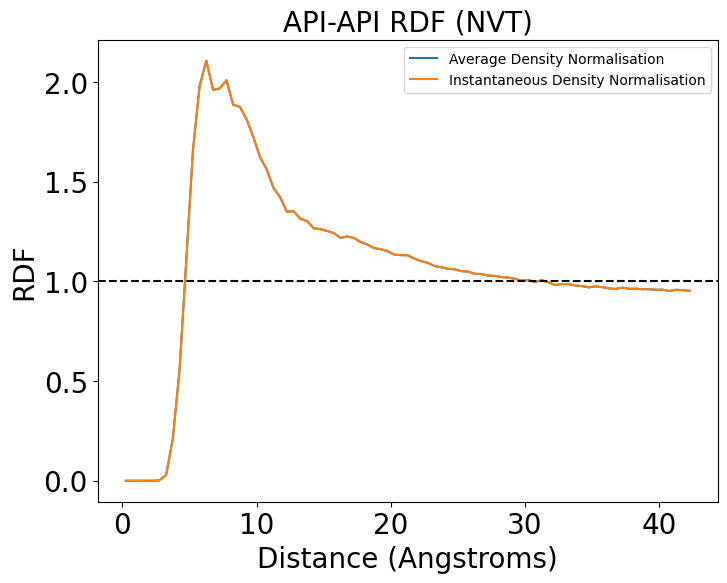

In [ ]:
import rdf_analysis
import matplotlib.pyplot as plt
import numpy as np

# ----- NVT Simulation ------

# Collecting the bins and the RDF
api_bins_nvt_avg, api_rdf_nvt_avg = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_nvt.npz",
    bin_width=0.5,
    instantaneous=False,
    start_time=2000,
)
api_bins_nvt_inst, api_rdf_nvt_inst = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_nvt.npz",
    bin_width=0.5,
    instantaneous=True,
    start_time=2000,
)

# Plotting this information for the check
plt.figure(figsize=(8, 6))
plt.plot(api_bins_nvt_avg, api_rdf_nvt_avg, label="Average Density Normalisation")
plt.plot(
    api_bins_nvt_inst, api_rdf_nvt_inst, label="Instantaneous Density Normalisation"
)
plt.xlabel("Distance (Angstroms)", fontsize=20)
plt.ylabel("RDF", fontsize=20)
plt.title("API-API RDF (NVT)", fontsize=20)
plt.axhline(y=1, linestyle="--", color="k")
plt.tick_params(labelsize=20)
plt.legend()
plt.savefig("manual_vs_mda_test_nvt.png", dpi=300)

# Printing the difference between the RDFs to see if the normalisations agree for a non fluctuating box
print(api_rdf_nvt_inst - api_rdf_nvt_avg)


We see when the box size doesn't fluctuate, the average density normalisation is nearly equivalent to an instantaneous density normalisation. Now as there are no pressure fluctuations in an NVT simulation, what is causing these VERY small fluctuations? Conventions not being completely equivalent when looking at the NVT case or numerical errors.

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.48408623e-06
  4.33170551e-05  4.72305450e-05 -3.95410416e-05  2.19897293e-06
  1.21508379e-04  1.15957484e-04  2.50682337e-05 -9.13893754e-05
 -1.20604137e-04 -2.18814393e-04  4.95605771e-06  1.24259343e-05
  1.80511846e-05  1.10520070e-04 -1.75142196e-05 -2.58563638e-04
  1.67252862e-04  5.99260197e-05  1.05682360e-04 -7.62809092e-05
  5.41611987e-06  7.90491398e-05  2.99176923e-04  1.05120500e-04
  6.35386951e-05  9.19541307e-05 -1.08030882e-04  9.21973394e-05
  1.36694371e-04  8.34706462e-05 -7.50381013e-05  8.99695940e-05
  7.58595067e-05  1.74220034e-04  1.96534788e-04  1.85666554e-04
  8.31530534e-05  6.32755232e-05  8.42220323e-05  2.04567109e-04
  6.85556785e-05  1.00114506e-04  2.02617609e-05  1.16244615e-04
  1.28114879e-04  6.91054

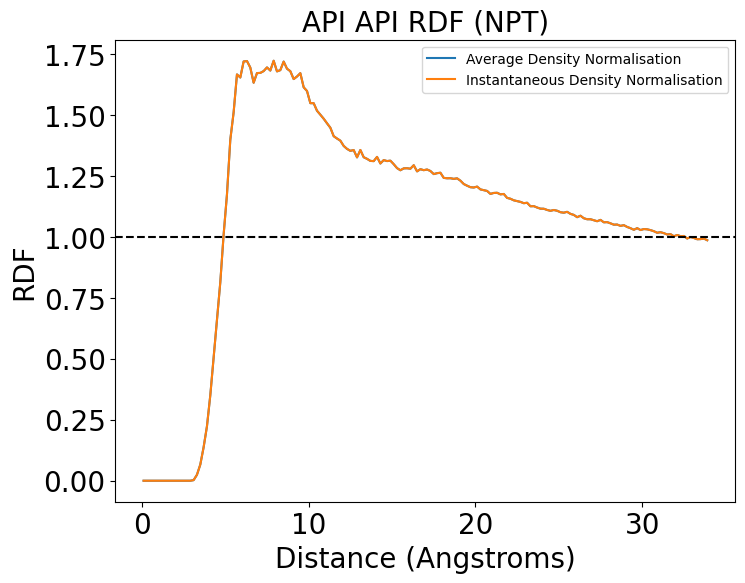

In [ ]:
# NPT RDF plots
api_bins_npt_avg, api_rdf_npt_avg = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_npt.npz",
    bin_width=0.2,
    instantaneous=False,
    start_time=2000,
)
api_bins_npt_inst, api_rdf_npt_inst = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_npt.npz",
    bin_width=0.2,
    instantaneous=True,
    start_time=2000,
)

# RDF Plotting
plt.figure(figsize=(8, 6))
plt.plot(api_bins_npt_avg, api_rdf_npt_avg, label="Average Density Normalisation")
plt.plot(
    api_bins_npt_inst, api_rdf_npt_inst, label="Instantaneous Density Normalisation"
)
plt.xlabel("Distance (Angstroms)", fontsize=20)
plt.ylabel("RDF", fontsize=20)
plt.title("API API RDF (NPT)", fontsize=20)
plt.tick_params(labelsize=20)
plt.axhline(y=1, linestyle="--", color="k")
plt.legend()
plt.savefig("manual_vs_mda_test_npt.png", dpi=300)

# Look at the difference between normalisation schemes
print(api_rdf_npt_inst - api_rdf_npt_avg)

There still looks like agreement however after printing out the difference in the values obtained in the normalisation, the difference in the two schmes are more pronounced. Will put them on the same plot to see what is going on. The binning should be the same for the two plots.

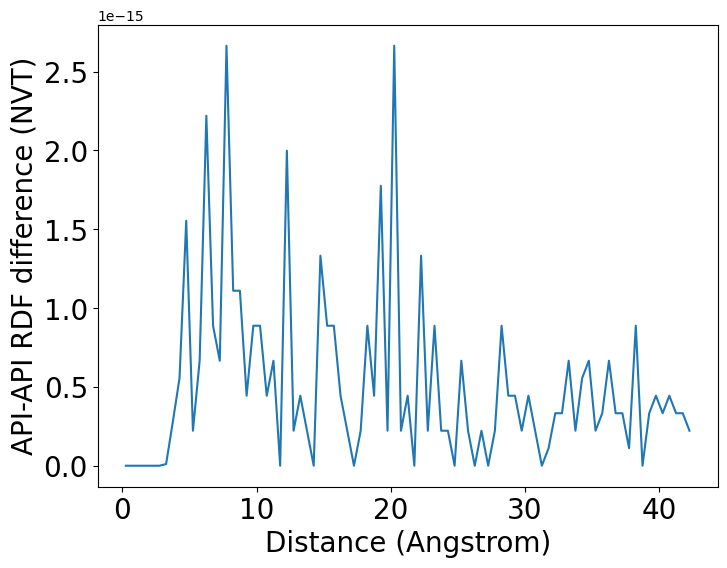

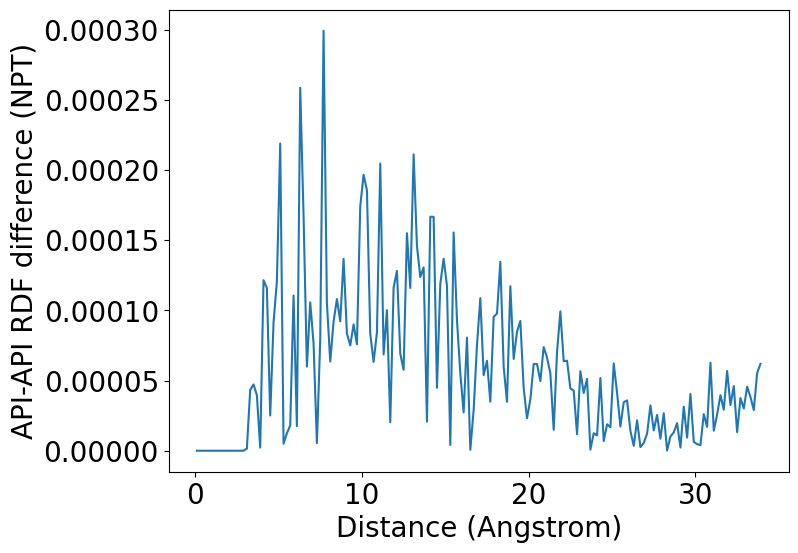

In [37]:
# Differences in the two normalisation schemes for the NVT and NPT simulations
api_nvt_diff = np.abs(api_rdf_nvt_inst - api_rdf_nvt_avg)
api_npt_diff = np.abs(api_rdf_npt_inst - api_rdf_npt_avg)

# Due to the NPT simulations having more bins (its a longer simulation), we cant actually plot these quantities on the same curve.
# Howver for a given sim, it doesnt matter what bins we use (average density or instantaneous density).
plt.figure(figsize=(8, 6))
plt.plot(api_bins_nvt_avg, api_nvt_diff)
plt.ylabel("API-API RDF difference (NVT)", fontsize=20)
plt.xlabel("Distance (Angstrom)", fontsize=20)
plt.tick_params(labelsize=20)
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.plot(api_bins_npt_avg, api_npt_diff)
plt.ylabel("API-API RDF difference (NPT)", fontsize=20)
plt.xlabel("Distance (Angstrom)", fontsize=20)
plt.tick_params(labelsize=20)
plt.show()
plt.close()

# Polymer-Polymer RDF

Have tried to adapt the API-API RDF code to make it relevant to the polymers...


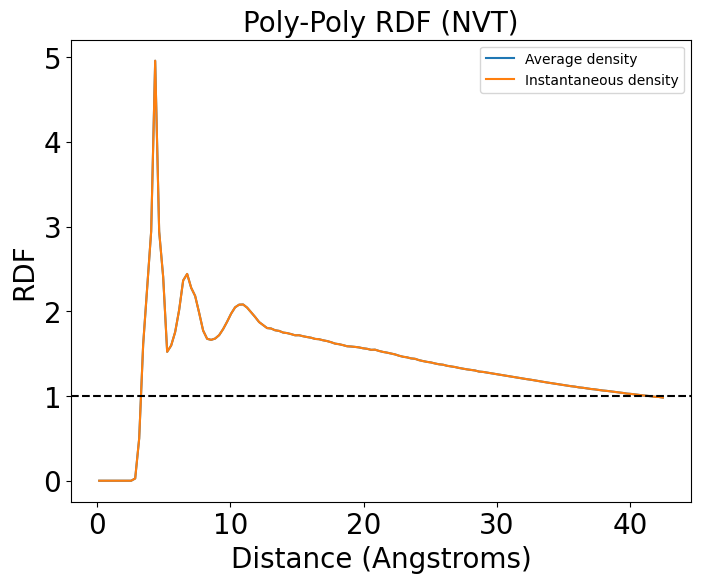

In [38]:
# ----- NVT Simulation ------
poly_bins_nvt_avg, poly_rdf_nvt_avg = rdf_analysis.polymer_polymer_rdf_manual(
    polymer_topology_file="dry_nvt_polymer.tpr",
    polymer_trajectory_file="dry_nvt_trim_polymers.xtc",
    reference_particle_name="N1",
    bin_width=0.3,
    instantaneous=False,
    start_time=2000,
)
poly_bins_nvt_inst, poly_rdf_nvt_inst = rdf_analysis.polymer_polymer_rdf_manual(
    polymer_topology_file="dry_nvt_polymer.tpr",
    polymer_trajectory_file="dry_nvt_trim_polymers.xtc",
    reference_particle_name="N1",
    bin_width=0.3,
    instantaneous=True,
    start_time=2000,
)

plt.figure(figsize=(8, 6))
plt.plot(poly_bins_nvt_avg, poly_rdf_nvt_avg, label="Average density")
plt.plot(poly_bins_nvt_inst, poly_rdf_nvt_inst, label="Instantaneous density")
plt.title("Poly-Poly RDF (NVT)", fontsize=20)
plt.xlabel("Distance (Angstroms)", fontsize=20)
plt.ylabel("RDF", fontsize=20)
plt.axhline(y=1, linestyle="--", color="k")
plt.tick_params(labelsize=20)
plt.legend()
plt.savefig("poly_poly_rdf_nvt.png", dpi=300)

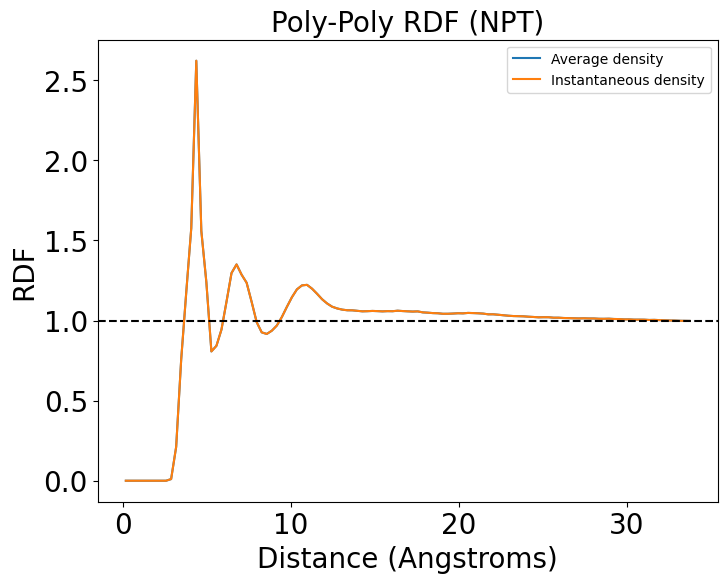

In [39]:
# ----- NPT Simulation ------
poly_bins_npt_avg, poly_rdf_npt_avg = rdf_analysis.polymer_polymer_rdf_manual(
    polymer_topology_file="dry_npt_polymer.tpr",
    polymer_trajectory_file="dry_npt_trim_polymers.xtc",
    reference_particle_name="N1",
    bin_width=0.3,
    instantaneous=False,
    start_time=2000,
)
poly_bins_npt_inst, poly_rdf_npt_inst = rdf_analysis.polymer_polymer_rdf_manual(
    polymer_topology_file="dry_npt_polymer.tpr",
    polymer_trajectory_file="dry_npt_trim_polymers.xtc",
    reference_particle_name="N1",
    bin_width=0.3,
    instantaneous=True,
    start_time=2000,
)
plt.figure(figsize=(8, 6))
plt.plot(poly_bins_npt_avg, poly_rdf_npt_avg, label="Average density")
plt.plot(poly_bins_npt_inst, poly_rdf_npt_inst, label="Instantaneous density")
plt.title("Poly-Poly RDF (NPT)", fontsize=20)
plt.xlabel("Distance (Angstroms)", fontsize=20)
plt.ylabel("RDF", fontsize=20)
plt.axhline(y=1, linestyle="--", color="k")
plt.tick_params(labelsize=20)
plt.legend()
plt.savefig("poly_poly_rdf_npt.png", dpi=300)

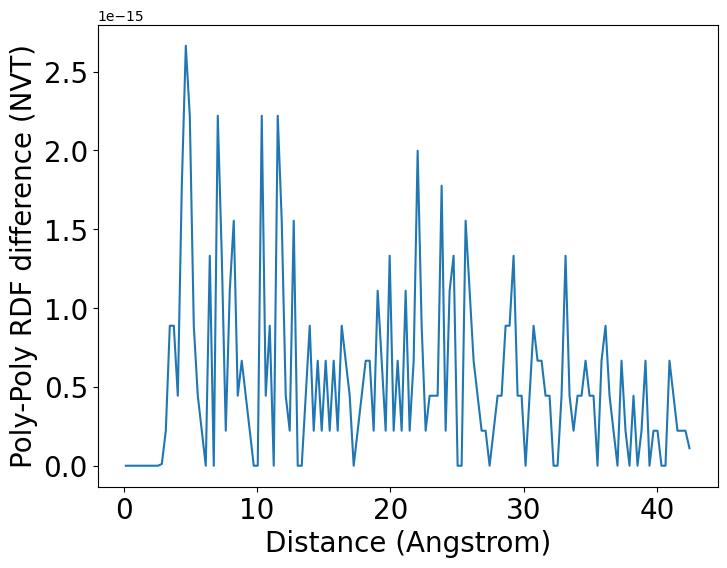

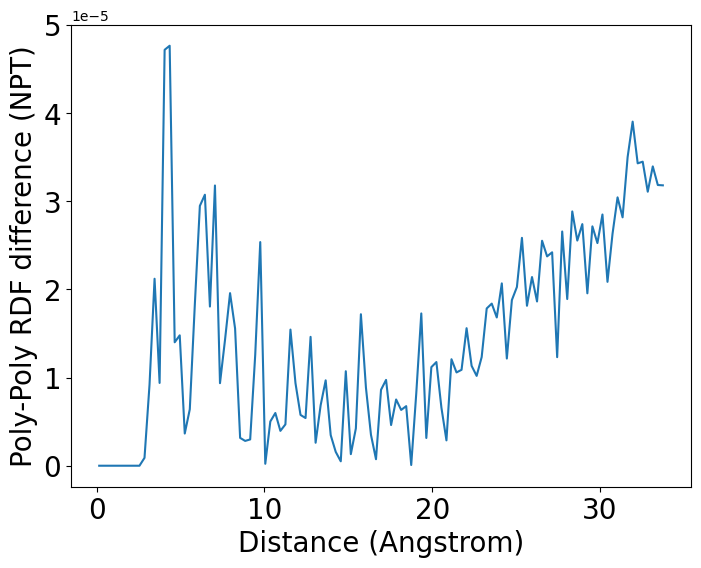

In [40]:
# Get the difference plots for poly-poly rdf
poly_nvt_diff = np.abs(poly_rdf_nvt_inst - poly_rdf_nvt_avg)
poly_npt_diff = np.abs(poly_rdf_npt_inst - poly_rdf_npt_avg)

plt.figure(figsize=(8, 6))
plt.plot(poly_bins_nvt_avg, poly_nvt_diff)
plt.ylabel("Poly-Poly RDF difference (NVT)", fontsize=20)
plt.xlabel("Distance (Angstrom)", fontsize=20)
plt.tick_params(labelsize=20)
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.plot(poly_bins_npt_avg, poly_npt_diff)
plt.ylabel("Poly-Poly RDF difference (NPT)", fontsize=20)
plt.xlabel("Distance (Angstrom)", fontsize=20)
plt.tick_params(labelsize=20)
plt.show()
plt.close()

### Polymer-API RDF 

API COM file test_api_nvt.npz already exists, skipping extraction.


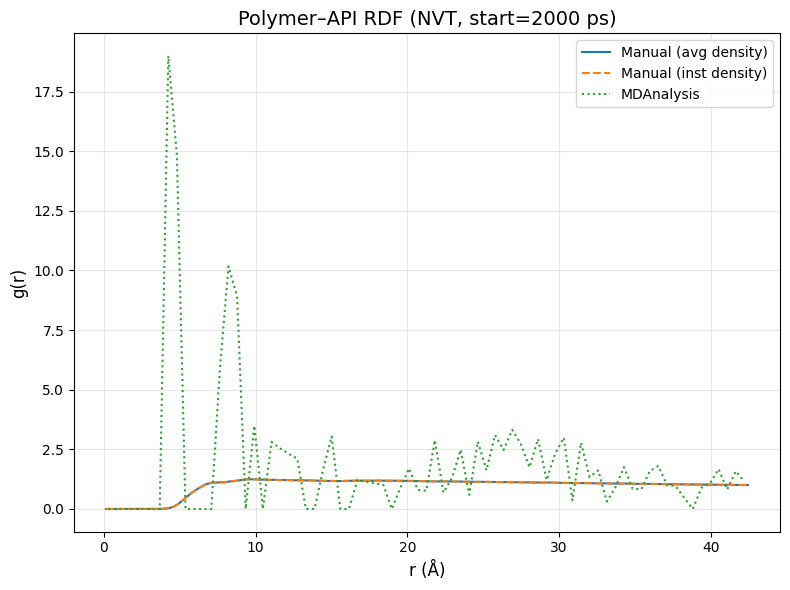

In [ ]:
# ----- NVT Simulation ------
poly_api_bins_nvt_avg, poly_api_rdf_nvt_avg = rdf_analysis.polymer_api_rdf_manual(
    polymer_topology_file="dry_nvt_polymer.tpr",
    polymer_trajectory_file="dry_nvt_trim_polymers.xtc",
    reference_particle_name="N1",
    simulation_information_filename="test_api_nvt.npz",
    bin_width=0.3,
    instantaneous=False,
)
poly_api_bins_nvt_inst, poly_api_rdf_nvt_inst = rdf_analysis.polymer_api_rdf_manual(
    polymer_topology_file="dry_nvt_polymer.tpr",
    polymer_trajectory_file="dry_nvt_trim_polymers.xtc",
    reference_particle_name="N1",
    simulation_information_filename="test_api_nvt.npz",
    bin_width=0.3,
    instantaneous=True,
)
